In [6]:
import pandas as pd
import numpy as np

# 데이터 불러오기
data1 = pd.read_csv('WallThining_data.csv')
data2 = pd.read_csv('WallThinning_3050_data.csv')
data3 = pd.read_csv('WallThinning_10_data.csv')
data4 = pd.read_csv('WallThinning_5.csv')
data = pd.concat([data1, data2, data3, data4], axis=0)
data = data.drop('Moment', axis=1).reset_index(drop=True)
# 데이터 확인
print(data.head())

  Thining Part Moment Direction Thining Rate Boundary Type  Inner Pressure  \
0        Extra              IPO          20%    Limit Load          22.070   
1        Extra              IPO          20%    Limit Load          19.863   
2        Extra              IPO          20%    Limit Load          17.656   
3        Extra              IPO          20%    Limit Load          15.449   
4        Extra              IPO          20%    Limit Load          13.242   

   Multiplier  
0    0.754368  
1    0.889164  
2    1.000607  
3    1.022539  
4    0.970476  


In [7]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max Scaler 객체 생성
scaler = MinMaxScaler()

# 'Inner Pressure' 열 선택 및 Reshape (-1, 1) 필요 (scaler는 2D 배열을 요구함)
inner_Pressure = data['Inner Pressure'].values.reshape(-1, 1)

# Min-Max Normalization 적용
data['Inner Pressure'] = scaler.fit_transform(inner_Pressure)

# 결과 확인
print(data.head())


  Thining Part Moment Direction Thining Rate Boundary Type  Inner Pressure  \
0        Extra              IPO          20%    Limit Load             1.0   
1        Extra              IPO          20%    Limit Load             0.9   
2        Extra              IPO          20%    Limit Load             0.8   
3        Extra              IPO          20%    Limit Load             0.7   
4        Extra              IPO          20%    Limit Load             0.6   

   Multiplier  
0    0.754368  
1    0.889164  
2    1.000607  
3    1.022539  
4    0.970476  


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

data = pd.get_dummies(data, columns=['Thining Part','Moment Direction','Boundary Type'])

# Numerical 변수 전처리 (Inner pressure)
data['Thining Rate'] = data['Thining Rate'].str.rstrip('%').astype('int')

# 데이터 분할
X = data.drop('Multiplier', axis=1)
y = data['Multiplier']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

param_dict = {
    'Decision Tree Regressor': {
        'max_depth': [None, 5, 6],  # default: None
        'min_samples_split': [2, 15, 30],  # default: 2
        'min_samples_leaf': [1, 5, 10],  # default: 1
        'max_features': [None, 'sqrt', 'log2']  # default: None
    },
    'Random Forest Regressor': {
        'n_estimators': [100, 1000, 2000],  # default: 100
        'max_depth': [None, 5, 6],  # default: None
        'min_samples_split': [2, 15, 30],  # default: 2
        'min_samples_leaf': [1, 5, 10],  # default: 1
        'max_features': ['auto', 'sqrt', 'log2']  # default: 'auto'
    },
    'Gradient Boosting Regressor': {
        'n_estimators': [100, 1000, 2000],  # default: 100
        'learning_rate': [0.1, 0.05, 0.01],  # default: 0.1
        'max_depth': [3, 5, 6],  # default: 3
        'min_samples_split': [2, 15, 30],  # default: 2
        'min_samples_leaf': [1, 5, 10],  # default: 1
    'subsample': [1.0, 0.8, 0.6]  # default: 1.0
    }
}

models = {
    # 'Decision Tree Regressor': DecisionTreeRegressor(),
    # 'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
}

# MAPE와 SMAPE 함수 정의
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2)) * 100

# 모델 학습 및 성능 평가
for name, model in models.items():
    
    param = param_dict.get(name)

    gs = GridSearchCV(estimator=model, param_grid=param, cv=3)
    gs.fit(X_train, y_train)
    y_pred = gs.predict(X_test)
    print(f"{name} 최적의 파라미터: {gs.best_params_}")
    print(f"{name} 최고 정확도: {gs.best_score_}")
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)
    
    print(f'{name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}, SMAPE: {smape:.4f}')


Gradient Boosting Regressor 최적의 파라미터: {'learning_rate': 0.05, 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 1000, 'subsample': 0.6}
Gradient Boosting Regressor 최고 정확도: 0.9905648297714542
Gradient Boosting Regressor - MAE: 0.0074, MSE: 0.0002, RMSE: 0.0136, MAPE: 1.2194, SMAPE: 1.2111


In [28]:
test_data = pd.read_csv('WallThinning_5_copy.csv')
test_data = test_data.drop('Moment', axis=1).reset_index(drop=True)

inner_Pressure = test_data['Inner Pressure'].values.reshape(-1, 1)
test_data['Inner Pressure'] = scaler.transform(inner_Pressure)

# 결과 확인
print(test_data.head())

  Thining Rate      Boundary Type Thining Part Moment Direction  \
0          15%  Elastic Shakedown        Extra              IPC   
1          15%  Elastic Shakedown        Extra              IPC   
2          15%  Elastic Shakedown        Extra              IPC   
3          15%  Elastic Shakedown        Extra              IPC   
4          15%  Elastic Shakedown        Extra              IPC   

   Inner Pressure  Multiplier  
0             0.0    0.358854  
1             0.1    0.398745  
2             0.2    0.448582  
3             0.3    0.512697  
4             0.4    0.597039  


In [29]:
test_data = pd.get_dummies(test_data, columns=['Thining Part','Moment Direction','Boundary Type'])
test_data['Thining Rate'] = test_data['Thining Rate'].str.rstrip('%').astype('int')

# 데이터 분할
val_X = test_data.drop('Multiplier', axis=1)
val_y = test_data['Multiplier']

In [31]:
zero_list = [0 for _ in range(198)]
val_X['Thining Part_Crown'] = zero_list
val_X['Thining Part_Intra'] = zero_list
val_X['Boundary Type_Limit Load'] = zero_list

In [32]:
pred_y = gs.predict(val_X)
reshape_pred = pred_y.reshape(-1, 11)
print(reshape_pred)

[[0.39625039 0.43621198 0.48627588 0.54738505 0.64172232 0.7673626
  0.90030353 0.94407801 0.9213729  0.85149807 0.7587474 ]
 [0.39609094 0.43462621 0.48289699 0.54316237 0.63998741 0.76819597
  0.89566588 0.91890911 0.89055804 0.8214421  0.73494126]
 [0.39122589 0.42346025 0.46193292 0.52120911 0.58485434 0.64797143
  0.71942767 0.7598674  0.7669591  0.7536719  0.72466955]
 [0.38783371 0.42865373 0.47850185 0.53674863 0.62947849 0.75067314
  0.88611937 0.93695556 0.91425044 0.84747909 0.75480361]
 [0.38702968 0.42634681 0.47406936 0.53153921 0.62605477 0.7480109
  0.87742945 0.90403161 0.87637444 0.8074989  0.72117874]
 [0.38141997 0.41373902 0.45177958 0.50759523 0.57026677 0.62992438
  0.70461191 0.75091688 0.75826066 0.74748673 0.71764536]
 [0.38783371 0.42865373 0.47850185 0.53674863 0.62947849 0.75067314
  0.88611937 0.93695556 0.91425044 0.84747909 0.75480361]
 [0.38702968 0.42634681 0.47406936 0.53153921 0.62605477 0.7480109
  0.87742945 0.90403161 0.87637444 0.8074989  0.72117

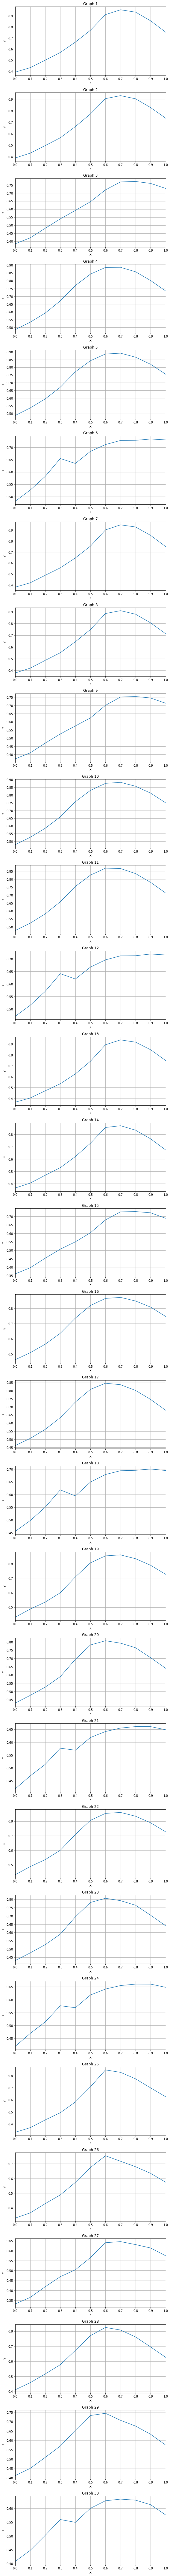

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# x축 값 설정 (0.0부터 1.0까지 11개의 값)
x = np.linspace(0.0, 1.0, 11)

# 각 내부 배열에 대한 그래프 그리기
fig, axs = plt.subplots(reshape_pred.shape[0], 1, figsize=(8, 4*reshape_pred.shape[0]))

for i in range(reshape_pred.shape[0]):
    axs[i].plot(x, reshape_pred[i])
    axs[i].set_title(f'Graph {i+1}')
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
    axs[i].set_xticks(x)
    axs[i].set_xlim(0.0, 1.0)
    axs[i].grid(True)

plt.tight_layout()
plt.show()